1/1 [==============================] - 0s 239ms/step
RNN RMSE: 459886.05442086415
RNN MAPE: 18.02%
1/1 [==============================] - 0s 171ms/step
LSTM RMSE: 526922.6989879208
LSTM MAPE: 17.10%
1/1 [==============================] - 0s 168ms/step
GRU RMSE: 496313.4758585958
GRU MAPE: 15.85%
1/1 [==============================] - 0s 241ms/step
Bidirectional RNN RMSE: 315226.2580731299
Bidirectional RNN MAPE: 12.50%


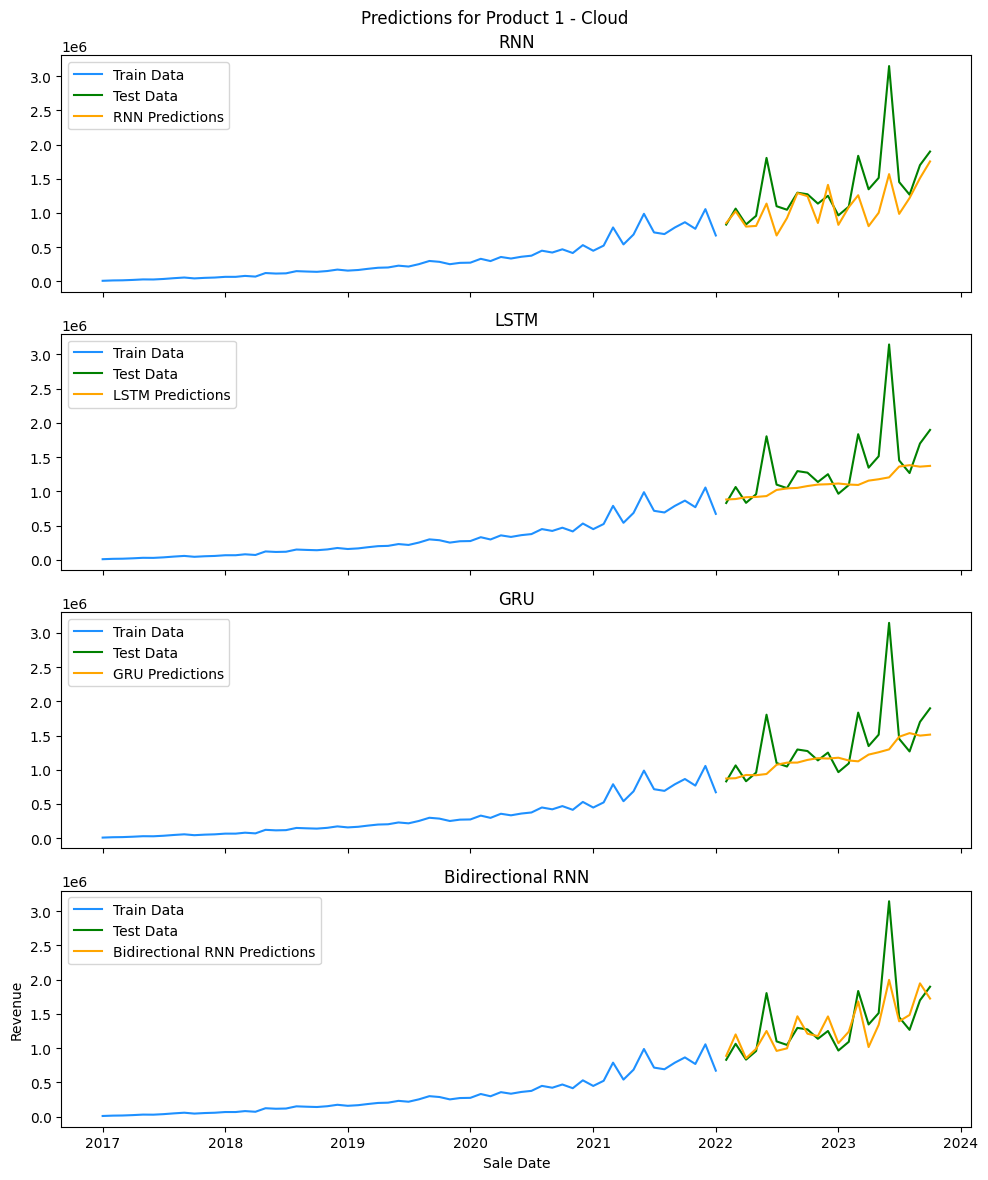

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import random

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load the data
url='https://drive.google.com/file/d/18Uy2KTXVthqdm-VWEI78zKTe6l_owPFn/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
raw_data = pd.read_csv(url)

# Change sale_date from object to datetime and sort
raw_data['sale_date'] = pd.to_datetime(raw_data['sale_date'])
raw_data = raw_data.sort_values('sale_date')
data = raw_data.loc[(raw_data['product_id'] == 'Product 1') & (raw_data['hosting'] == 'Cloud')]
data = data[:-1]

# data['log_revenue'] = np.log(data['revenue'])
# data['log_revenue_diff'] = data['log_revenue'].diff().fillna(0)

#scale the target (revenue)
scaler = MinMaxScaler(feature_range=(0,1))
data['scaled_revenue'] = scaler.fit_transform(data[['revenue']])

#reshape the data and split into train/test
window_size = 12
X, y = create_sequences(data['scaled_revenue'].values, window_size)

train_size = int(len(X) * 0.7)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# building models
models = {
    'RNN': create_model('RNN', (window_size, 1)),
    'LSTM': create_model('LSTM', (window_size, 1)),
    'GRU': create_model('GRU', (window_size, 1)),
    'Bidirectional RNN': bidirectional_rnn((window_size, 1))
}

# model tarining
mape = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train, epochs=200, batch_size=12, verbose=0)
    pred = model.predict(X_test).flatten()

    # last_log_revenue = data['log_revenue'].iloc[train_size - 1]
    # inverse_log_diff = np.concatenate(([last_log_revenue], pred)).cumsum()[1:]
    # inverse_predictions = np.exp(pred)
    # predictions[name] = inverse_predictions

    pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    predictions[name] = pred

    actual_revenue = data.iloc[train_size + window_size:]['revenue']

    # calculate RMSE and MAPE
    rmse = np.sqrt(mean_squared_error(actual_revenue, predictions[name]))
    mape[name] = mean_absolute_percentage_error(actual_revenue, predictions[name]) * 100

    print(f"{name} RMSE: {rmse}")
    print(f"{name} MAPE: {mape[name]:.2f}%")

# graph the results
train_dates = data.iloc[:train_size + window_size]['sale_date']
test_dates = data.iloc[train_size + window_size:]['sale_date']

fig, axs = plt.subplots(len(models), figsize=(10, 12), sharex=True, sharey=True)
fig.suptitle('Predictions for Product 1 - Cloud')
fig.patch.set_alpha(0)

for i, (name, pred) in enumerate(predictions.items()):
    axs[i].plot(train_dates, data.iloc[:train_size + window_size]['revenue'], label="Train Data", color="dodgerblue")
    axs[i].plot(test_dates, data.iloc[train_size + window_size:]['revenue'], label="Test Data", color="green")
    axs[i].plot(test_dates, pred, label=f"{name} Predictions", color="orange")
    axs[i].legend()
    axs[i].set_title(name)

plt.xlabel("Sale Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


In [7]:
# create sequences for RNN
def create_sequences(data, window_size):
    sequences, labels = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

In [8]:
# RNN models
def create_model(model_type, input_shape):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(64, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(SimpleRNN(32, activation = "relu"))
        model.add(Dense(12))
        # model.add(SimpleRNN(32, activation = "relu"))
    elif model_type == 'LSTM':
        model.add(LSTM(64, activation='relu', input_shape=input_shape))
        # model.add(LSTM(32, return_sequences = False))
        model.add(Dense(32))
        model.add(Dense(12))
    elif model_type == 'GRU':
        model.add(GRU(64, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def bidirectional_rnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(64, activation='relu'), input_shape=input_shape))
    # model.add(Bidirectional(SimpleRNN(32, activation='relu')))
    model.add(Dense(32))
    model.add(Dense(12))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model